In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")
import os
import ase
import time
import numpy as np
import ase.io as aio
import scipy.io as sio
import matplotlib.pyplot as plt
import poremks.porosity as pore
import poremks.grid_generator as gen
from poremks.helpers import write2vtk
from toolz.curried import pipe, curry

## Load Structure of Interest

### For an amorphous hydrocarbon macromolecular structure

In [3]:
cif = "EFK_50A_0.80.xyz"
fname = os.path.join("hydrocarbons", "EFK_50A_0.80.xyz")

rep = [1]*3
radii={"C":1.7, "H": 1.1, "O": 1.52}
len_pixel=10

### For a 3D bulk zeolite

In [4]:
cif = "MFI.cif"
fname = os.path.join("input3dSlabs", cif)

rep = [1]*3
len_pixel = 10
radii={"Si":1.35, "O": 1.35}

### Load the structure information using ase library as an atom object

In [5]:
atom = pipe(fname, 
            lambda fname: aio.read(fname), 
            lambda x: x.repeat(rep))

print("No. of atoms in the structure: %d" % len(atom))

No. of atoms in the structure: 288


## Generate Voxelized Representation of the Pore Structure

In [6]:
%%time


S, S_list, box_dim = gen.grid_maker(atom, len_pixel=10, radii=radii, full=False, fft=True)
print(S.shape)

(202, 198, 133)
CPU times: user 1.71 s, sys: 292 ms, total: 2 s
Wall time: 1.05 s


## Conventional Pore Metrics - PLD and LCD

In [7]:
strt = time.time()
padval = ((1, 1), (1, 1), (0, 0)) 
S_dgrid = pipe(S,
               lambda s: np.pad(s, padval, 'constant', constant_values=0),
               lambda s: pore.dgrid(s, len_pixel=len_pixel))
end = time.time()
print("distance grid computation time: %1.3fs"%(end-strt))

strt = time.time()
pld  = pore.get_pld(S_dgrid)
end  = time.time()
print("PLD: %1.3f" % pld)
print("PLD computation time: %1.3fs"%(end-strt))

strt = time.time()
lcd  = pore.get_lcd(S_dgrid)
end  = time.time()
print("LCD: %1.3f" % lcd)
print("LCD computation time: %1.3fs"%(end-strt))

distance grid computation time: 0.446s
PLD: 2.617
PLD computation time: 0.553s
LCD: 6.723
LCD computation time: 0.002s


### For PLD in a different direction

In [8]:
%%time
padval = ((1, 1), (1, 1), (0, 0)) 
pld = pipe(S, 
           lambda s: np.rot90(s, axes=(0,2)),
           lambda s: np.pad(s, padval, 'constant', constant_values=0),
           lambda s: pore.dgrid(s, len_pixel=len_pixel),
           lambda s: pore.get_pld(s))
print(pld)

4.3046875
CPU times: user 1.37 s, sys: 212 ms, total: 1.58 s
Wall time: 1.07 s


# Geometric analysis of diffusion pathways

- Convert admissible coordinates to graph structure
 - generate adjacency matrix from graph structure
 - use adjacency matrix to identify shortest paths
 - use a Shortest Path heuristic on the adjacency matrix to prune the medial axis network of dead ends.
 - for the pruned path, use eculidean distance from nearest atoms at each path voxel as a metric of pore size distribution

In [9]:
strt = time.time()
S_1 = (pore.gen_cleanPore(S_dgrid, r_probe=1.0, r_min=2.5, len_pixel=len_pixel) > 0) * 1
end = time.time()
print("Pore Cleaning Computation Time: %1.3fs" % (end-strt))

Pore Cleaning Computation Time: 0.177s


In [10]:
strt = time.time()
S_11 = np.pad(S_1, pad_width=((0,0),(0,0),(len_pixel, len_pixel)), mode = "constant", constant_values=1)
S_2 = pore.gen_medialAxis(S_11)[:,:,len_pixel:-len_pixel]
end = time.time()
print("Medial Path Computation Time: %1.3fs" % (end-strt))

Medial Path Computation Time: 1.887s


In [11]:
strt = time.time()
S_3, paths = pore.gen_throughPath(S_2, depth=1)
end = time.time()
print("Through Path Computation Time: %1.3fs" % (end-strt))
print("Mean and setdev of path lengths: %1.3f, %1.3f" % (np.mean(paths), np.std(paths)))

Through Path Computation Time: 0.835s
Mean and setdev of path lengths: 2.860, 0.085


In [12]:
n_paths = len(pore.return_labelled(S_1)[-1])
print("No. of unique paths: %d" % n_paths)

No. of unique paths: 1


In [13]:
asa = pore.get_asa(S_1, len_pixel=10)
print("Probe Accessible Surface Area: %1.3f" % asa)
av = np.count_nonzero(S_1) * (1 / len_pixel)**3
print("Probe Accessible Volume: %1.3f" % av)

Probe Accessible Surface Area: 1543.670
Probe Accessible Volume: 720.278


In [14]:
psd = S_dgrid[S_2==1]
print("Mean and setdev of pore size distribution: %1.3f, %1.3f" % (np.mean(psd), np.std(psd)))

Mean and setdev of pore size distribution: 1.893, 0.583


In [15]:
dim = np.asarray(S.shape) / len_pixel
print("dimensions of the structure: ", dim)

dimensions of the structure:  [20.2 19.8 13.3]


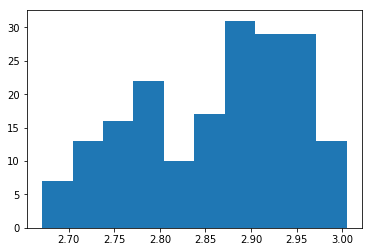

In [16]:
plt.hist(paths)
plt.show()

### Save the grids as vtk files, for 3D visualization in paraview

In [17]:
%%time
write2vtk(S_1, "%s_pore.vtk" % cif)
write2vtk(S_3, "%s_through_path.vtk" % cif)

CPU times: user 4.18 s, sys: 248 ms, total: 4.43 s
Wall time: 4.43 s
